In [1]:
import sys
sys.path.extend(["../../../../"])

In [2]:
import numpy as np
from onsager.crystal import Crystal
from onsager.crystalStars import zeroclean
from onsager.OnsagerCalc import *
from onsager.crystal import DB_disp, DB_disp4, pureDBContainer, mixedDBContainer
from onsager.DB_structs import dumbbell, SdPair, jump, connector

from scipy.constants import physical_constants
kB = physical_constants['Boltzmann constant in eV/K'][0]
from matplotlib import pyplot as plt
from collections import defaultdict

import pickle

In [3]:
%%time
with open("FeX_60RT.pkl","rb") as fl:
    onsagercalculator = pickle.load(fl)

CPU times: user 8min 27s, sys: 3.8 s, total: 8min 31s
Wall time: 8min 28s


In [5]:
# Assign same labels to the states as in the Fe-Cr notebook
name_to_themo_star = {"1nnA":2, "1nnB":1, "2nnA":4, "2nnB":3, "3nnA": 7, "3nnB":5, "3nnC":6,
       "4nnA":11,"4nnB":10,"4nnC":9, "4nnD":8, "5nnA":13, "5nnB":12}

In [6]:
# sorting out the jumps with the nomenclatures
jmpdict = {"1nnA_2nnA":[], "1nnA_2nnB":[], "1nnA_3nnB":[], "1nnA_3nnC":[], "1nnB_2nnB":[], "1nnB_3nnB":[],
          "1nnB_5nnB":[], "2nnA_4nnC":[], "2nnB_4nnB":[], "2nnB_4nnC":[]}
# Now identify the jumps and put them into the dictionaries
for jlistind, jlist in enumerate(onsagercalculator.jnet1):
    jmp = jlist[0]
    state1 = jmp.state1
    state2 = jmp.state2
    # if rigid jump, then continue
    if jmp.state1.db.iorind == jmp.state2.db.iorind:
        continue
    star1 = onsagercalculator.kinetic.complexIndexdict[state1][1]
    star2 = onsagercalculator.kinetic.complexIndexdict[state2][1]
    
    if star1 in onsagercalculator.thermo2kin and star2 in onsagercalculator.thermo2kin:
        thermo_star1 = onsagercalculator.thermo.complexIndexdict[state1][1]
        thermo_star2 = onsagercalculator.thermo.complexIndexdict[state2][1]
        name1 = ""
        name2 = ""
        #Now see which categories the states belong to
        star1found = False
        count1 = 0
        star2found = False
        count2 = 0
        for (key, value) in name_to_themo_star.items():
            if thermo_star1==value:
                star1found = True
                count1 += 1
                name1 = key
            if thermo_star2==value:
                star2found = True
                count2 += 1
                name2 = key
        # just to ensure we don't have any multiple counting business going on.
        if count1>1:
            print(thermo_star1)
        if count2>1:
            print(thermo_star2)
        # Now concatenate names
        jname = name1+"_"+name2
        jnameRev = name2+"_"+name1
        try:
            jmpdict[jname].append(jlistind)
        except:
            try:
                # maybe the jump we have is the reverse of what we stored as the label in the dictionary?
                jmpdict[jnamerev].append(jlistind)
            
            except:    
                continue

jmpdict

{'1nnA_2nnA': [1],
 '1nnA_2nnB': [3],
 '1nnA_3nnB': [4],
 '1nnA_3nnC': [2],
 '1nnB_2nnB': [6],
 '1nnB_3nnB': [7],
 '1nnB_5nnB': [5],
 '2nnA_4nnC': [10],
 '2nnB_4nnB': [9],
 '2nnB_4nnC': [8]}

In [7]:
E_f_pdb = 4.081701163
name_to_en = {"1nnA": -2078.60753537,"1nnB": -2078.65632730,"2nnA": -2078.54414323,"2nnB": -2078.61878894,
              "3nnA": -2078.56041027,"3nnB": -2078.58731551,"3nnC": -2078.55617904,"4nnA": -2078.57491324,
              "4nnB": -2078.61805864,"4nnC": -2078.59907718,"5nnA": -2078.60270459,"5nnB": -2078.56758108}

In [10]:
E_sup_pdb = -2081.44451396
E_sup_solute = -2074.36428964 
E_bulk = -2077.21734574  #E_bulk is the same as E_ref
name_to_Ef = defaultdict(float)
for (key, E_IB) in name_to_en.items():
    # get the binding energy first
    Eb = -E_IB + E_sup_pdb + E_sup_solute - E_bulk
    # Next, get the formation energy (relative to solute formation energy)
    name_to_Ef[key] = E_f_pdb - Eb
name_to_Ef["4nnD"] = E_f_pdb
name_to_Ef

defaultdict(float,
            {'1nnA': 4.065623653000623,
             '1nnB': 4.016831723000289,
             '2nnA': 4.129015793000528,
             '2nnB': 4.054370083000615,
             '3nnA': 4.112748753000526,
             '3nnB': 4.08584351300062,
             '3nnC': 4.116979983000258,
             '4nnA': 4.098245783000332,
             '4nnB': 4.055100383000374,
             '4nnC': 4.074081843000224,
             '5nnA': 4.070454433000416,
             '5nnB': 4.105577943000592,
             '4nnD': 4.081701163})

In [11]:
# The complex energies are set. Now, we set the mixed dumbbell energies
E_b_mdb = 2078.40083722 + E_sup_pdb + E_sup_solute - E_bulk
E_f_mdb = E_f_pdb - E_b_mdb
E_f_mdb - E_f_pdb

0.19062064000036116

In [12]:
# Energy values taken from database

# J_3_1nnA_2nnA   -2078.2548              4.4447
# J_3_1nnA_2nnB   -2078.2962              4.4447
# J_3_1nnA_3nnB   -2078.2468              4.4447
# J_3_1nnA_3nnC   -2078.2414              4.4447
# J_3_1nnB_2nnB   -2078.3442              4.4447
# J_3_1nnB_3nnB   -2078.2602              4.4447
# J_3_1nnB_5nnB   -2078.2517              4.4447
# J_3_2nnA_4nnC   -2078.2413              4.4447
# J_3_2nnB_4nnB   -2078.3302              4.4447
# J_3_2nnB_4nnC   -2078.2830              4.4447

Jname_2_TS_en = {"1nnA_2nnA": -2078.2548, "1nnA_2nnB": -2078.2962, "1nnA_3nnB": -2078.2468,
                 "1nnA_3nnC": -2078.2414, "1nnB_2nnB": -2078.3442, "1nnB_3nnB": -2078.2602,
                 "1nnB_5nnB": -2078.2517, "2nnA_4nnC": -2078.2413, "2nnB_4nnB": -2078.3302, 
                 "2nnB_4nnC": -2078.2830}

In [13]:
# Now, we have to find the TS energies.
Jname_2_ef_ts = defaultdict(float)
for (key, E_IB) in Jname_2_TS_en.items():
    Eb = -E_IB + E_sup_pdb + E_sup_solute - E_bulk
    # Next, get the formation energy (relative to solute formation energy)
    Jname_2_ef_ts[key] = E_f_pdb - Eb

In [14]:
Jname_2_mig = defaultdict(float)
for (key, TS_en) in Jname_2_ef_ts.items():
    initstar = key[:4]
    Jname_2_mig[key] = TS_en - name_to_Ef[initstar]
Jname_2_mig

defaultdict(float,
            {'1nnA_2nnA': 0.3527353699996638,
             '1nnA_2nnB': 0.3113353699995969,
             '1nnA_3nnB': 0.3607353699999294,
             '1nnA_3nnC': 0.3661353699999381,
             '1nnB_2nnB': 0.31212730000015654,
             '1nnB_3nnB': 0.3961272999999892,
             '1nnB_5nnB': 0.4046273000003566,
             '2nnA_4nnC': 0.3028432299997803,
             '2nnB_4nnB': 0.28858893999995416,
             '2nnB_4nnC': 0.3357889399999294})

In [15]:
# omega2 and omega43 Johnson jumps
E_IB_43, E_IB_2 = -2078.3178,  -2077.9373 
Eb_43, Eb_2 = -E_IB_43 + E_sup_pdb + E_sup_solute - E_bulk, -E_IB_2 + E_sup_pdb + E_sup_solute - E_bulk 
# Next, get the formation energy (relative to solute formation energy)
ef_ts_43 = E_f_pdb - Eb_43
ef_ts_2 = E_f_pdb - Eb_2
# print(ef_ts_2, ef_ts_43)
print(ef_ts_2-E_f_mdb, ef_ts_43 - name_to_Ef["1nnB"])

0.4635372200000347 0.3385273000003508


In [19]:
# get the SCMF PDC data from the file to compare to
temp = []
pdcr = []
with open("PDC_ratio_Ni.dat", "r") as fl:
    for line in fl:
        arr = line.split()
        temp.append(float(arr[0]))
        pdcr.append(float(arr[1]))
temp = np.array(temp)
pdcr = np.array(pdcr)

drag = []
with open("DragRatio_Ni.dat","r") as fl:
    for line in fl:
        arr = line.split()
        drag.append(float(arr[0]))
drag = np.array(drag)

## Ni calculations

In [17]:
vu0 = 4.4447
vu2 = 2.8285
Dconv=1e-2

predb0, enedb0 = np.ones(1)*np.exp(0.05), np.array([E_f_pdb])

# We'll measure every formation energy relative to the solute formation energy.
preS, eneS = np.ones(1), np.array([0.0])

# Next, interaction or the excess energies and pre-factors for solutes and dumbbells.
preSdb, eneSdb = np.ones(onsagercalculator.thermo.mixedstartindex), \
                 np.zeros(onsagercalculator.thermo.mixedstartindex)
# Now, we go over the necessary stars and assign interaction energies
for (key, index) in name_to_themo_star.items():
    eneSdb[index] = name_to_Ef[key] - E_f_pdb

predb2, enedb2 = np.ones(1), np.array([E_f_mdb])

# Transition state energies
# Omega0 TS eneriges
preT0, eneT0 = Dconv*vu0*np.ones(1), np.array([E_f_pdb+0.335115123])

# Omega2 TS energies
Nj2 = len(onsagercalculator.jnet2)
preT2, eneT2 = Dconv*vu2*np.ones(Nj2), np.array([ef_ts_2])

# Omega43 TS energies
preT43, eneT43 = Dconv*vu0*np.ones(1), np.array([ef_ts_43])

# Omega1 TS energies - need to be careful here
preT1 = Dconv*vu0*np.ones(len(onsagercalculator.jnet1))
eneT1 = np.array([eneT0[i] for i in onsagercalculator.om1types])
# Now, we go over the jumps that are provided and make the necessary changes
for (key, index) in jmpdict.items():
    eneT1[index] = Jname_2_ef_ts[key]

In [18]:
# Then we calculate the transport coefficients
from tqdm import tqdm

diff_aa_Ni = np.zeros(len(temp))
diff_ab_Ni = np.zeros(len(temp))
diff_bb = np.zeros(len(temp))
diff_bb_non_loc = np.zeros(len(temp))

start = time.time()
for i in tqdm(range(len(temp)), position=0, leave=True):
    T = temp[i]
    kT = kB*T
    bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
        onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                               preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)

    # get the probabilities and other data from L_ij
    L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
    onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)
    
    L_aa = L_uc_aa + L_c_aa
    L_bb = L_uc_bb + L_c_bb
    L_ab = L_uc_ab + L_c_ab
    
    diff_aa_Ni[i] = L_aa[0][0]
    diff_ab_Ni[i] = L_ab[0][0]
    diff_bb[i] = L_bb[0][0]
    diff_bb_non_loc[i] = L0bb[0][0]
        
print(time.time() - start)

100%|██████████| 381/381 [26:43<00:00,  4.21s/it]

1603.6232912540436


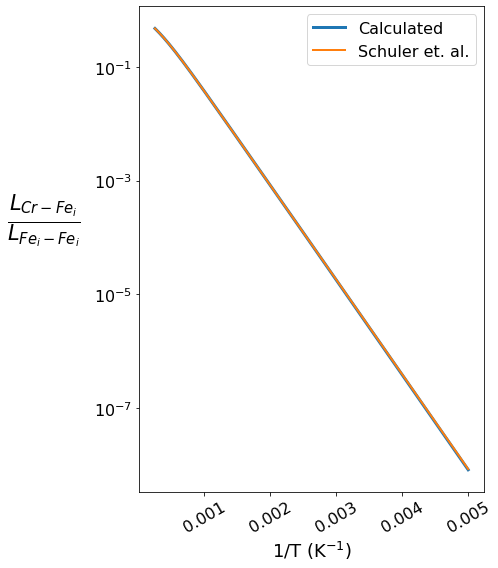

In [20]:
# Next, compare the pdc ratio
plt.figure(figsize=(7,8))
plt.semilogy(1/temp, diff_ab_Ni/(diff_bb_non_loc), label="Calculated", linewidth=3)
plt.semilogy(1/temp, np.array(pdcr), linewidth=2,
             label="Schuler et. al.")
plt.xlabel(r"1/T (K$^{-1}$)", fontsize=18)
plt.ylabel(r"$\frac{L_{Cr-Fe_i}}{L_{Fe_i-Fe_i}}$", fontsize=30, rotation = 0, labelpad=50)

plt.xticks(fontsize=16, rotation = 30)
plt.yticks(fontsize=16)
# plt.xlim(400, 1301)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.savefig("pdc_ratio_Cr_Fe_log.png")

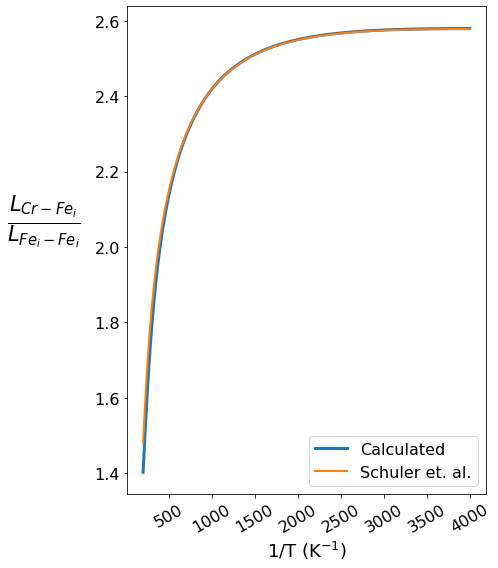

In [21]:
# Next, compare the drag ratio
plt.figure(figsize=(7,8))
plt.plot(temp, diff_ab_Ni/(diff_aa_Ni), label="Calculated", linewidth=3)
plt.plot(temp, np.array(drag), linewidth=2,
             label="Schuler et. al.")
plt.xlabel(r"1/T (K$^{-1}$)", fontsize=18)
plt.ylabel(r"$\frac{L_{Cr-Fe_i}}{L_{Fe_i-Fe_i}}$", fontsize=30, rotation = 0, labelpad=50)
# plt.legend(loc="best", fontsize=16)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=16, rotation = 30)
plt.yticks(fontsize=16)
# plt.xlim(400, 1301)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.savefig("pdc_ratio_Cr_Fe_log.png")

In [23]:
import h5py
with h5py.File("Ni_data_60RT.h5","w") as fl:
    fl.create_dataset("diff_aa", data=diff_aa_Ni)
    fl.create_dataset("diff_ab", data=diff_ab_Ni)
    fl.create_dataset("diff_bb_nl", data=diff_bb_non_loc)
    fl.create_dataset("diff_bb", data=diff_bb)
    fl.create_dataset("Temp", data=temp)

In [25]:
# Now let's do the infinite temeperature limit
kT = np.inf
bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
    onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                           preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)
#     bFdicts[i] = [bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4]
# get the probabilities and other data from L_ij
L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)

L_aa = L_uc_aa + L_c_aa
L_bb = L_uc_bb + L_c_bb
L_ab = L_uc_ab + L_c_ab

In [26]:
L_ab[0][0]/L_aa[0][0]

2.521860980638909

In [27]:
# Jump rates and energy barriers set. Now, let's set the calculations up.
# at infinite temp, all energies can be taken to be zero since (delE/kT) will be zero anyway
predb0, enedb0 = np.ones(1)*np.exp(0.05), np.array([0.])

# We'll measure every formation energy relative to the solute formation energy.
preS, eneS = np.ones(1), np.array([0.0])

# Next, interaction or the excess energies and pre-factors for solutes and dumbbells.
preSdb, eneSdb = np.ones(onsagercalculator.thermo.mixedstartindex), \
                 np.zeros(onsagercalculator.thermo.mixedstartindex)

predb2, enedb2 = np.ones(1), np.array([0.])

# Transition state energies - For omega0, omega2 and omega43, the first type is the Johnson jump,
# and the second one is the Rigid jump.

# Omega0 TS eneriges
preT0, eneT0 = Dconv*vu0*np.ones(1), np.array([0.])

# Omega2 TS energies
Nj2 = len(onsagercalculator.jnet2)
preT2, eneT2 = Dconv*vu2*np.ones(Nj2), np.array([0.])

# Omega43 TS energies
preT43, eneT43 = Dconv*vu0*np.ones(1), np.array([0.])

# Omega1 TS energies - need to be careful here
preT1 = Dconv*vu0*np.ones(len(onsagercalculator.jnet1))
eneT1 = np.array([eneT0[i] for i in onsagercalculator.om1types])
# # Now, we go over the jumps that are provided and make the necessary changes
# for (key, index) in jmpdict.items():
#     eneT1[index] = Jname_2_ef_ts[key]
    
# # set origin state jumps to zeros - the code handles this anyway
# eneT1[0] = 0.0

In [28]:
# Now let's do the infinite temeperature limit again but at kT=1
kT = 1.  # Since energies are already set to zero, this should not matter
bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
    onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                           preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)
#     bFdicts[i] = [bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4]
# get the probabilities and other data from L_ij
L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)

L_aa = L_uc_aa + L_c_aa
L_bb = L_uc_bb + L_c_bb
L_ab = L_uc_ab + L_c_ab

In [29]:
# verify with the result of np.inf
L_ab[0][0]/L_aa[0][0]

2.521860980638909